# ViTMatte

El mateado de imágenes (REF: https://paperswithcode.com/task/image-matting) es la tarea de estimar con precisión el objeto en primer plano en imágenes y videos. Esto se utiliza, por ejemplo, en tu teléfono cuando se toma un selfie "retrato", desenfocando el fondo (vea, por ejemplo, cómo Google hace esto para el Pixel 6).

ViTMatte (REF: https://arxiv.org/abs/2305.15272) solo agrega un decodificador liviano encima de un Vision Transformer simple, lo que hace que la columna vertebral haga el trabajo pesado.

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

# Carga de imagen
En el mateado de imágenes, una "pista" que los investigadores suelen utilizar al desarrollar un algoritmo de mateado de imágenes es el llamado trimap. Un trimap es un mapa de sugerencias etiquetado manualmente, donde los usuarios simplemente delinean el primer plano (blanco) y el fondo (negro) de una imagen determinada y el algoritmo de mateado luego calcula la transparencia o los llamados valores alfa solo en el resto de regiones desconocidas (gris).

El modelo ViTMatte espera tanto la imagen como el trimap como entrada.

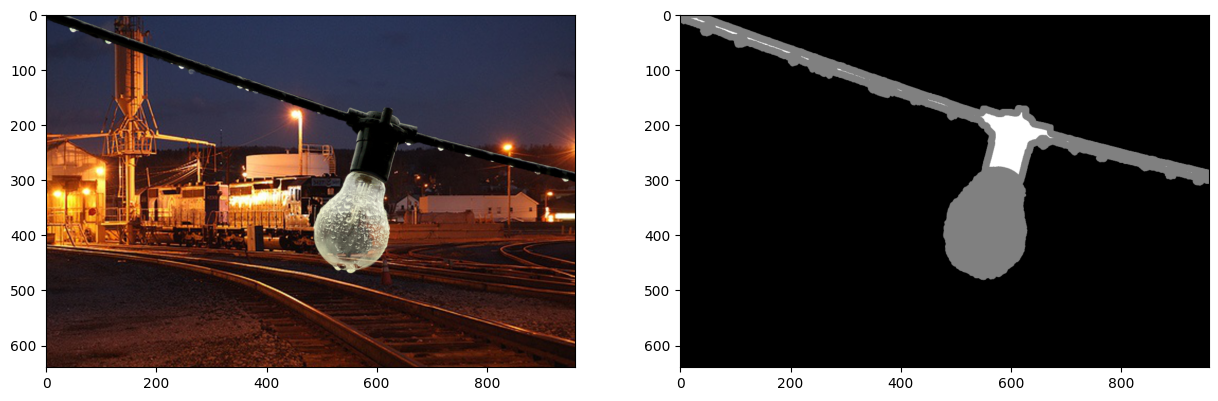

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import requests

url = "https://github.com/hustvl/ViTMatte/blob/main/demo/bulb_rgb.png?raw=true"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
url = "https://github.com/hustvl/ViTMatte/blob/main/demo/bulb_trimap.png?raw=true"
trimap = Image.open(requests.get(url, stream=True).raw)

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(trimap)
plt.show()

# Cargar el modelo

In [3]:
from transformers import VitMatteImageProcessor, VitMatteForImageMatting
import warnings
warnings.filterwarnings("ignore")

processor = VitMatteImageProcessor.from_pretrained("hustvl/vitmatte-small-distinctions-646")
model = VitMatteForImageMatting.from_pretrained("hustvl/vitmatte-small-distinctions-646")

2024-07-06 14:44:39.888702: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-06 14:44:39.888821: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-06 14:44:39.993213: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/284 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/837 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/103M [00:00<?, ?B/s]

In [5]:
# preparar imagen + trimap para el modelo
pixel_values = processor(images=image, trimaps=trimap.convert("L"), return_tensors="pt").pixel_values
print(pixel_values.shape)

torch.Size([1, 4, 640, 960])


# Forward pass

In [6]:
import torch
with torch.no_grad():
  outputs = model(pixel_values)

In [7]:
outputs.alphas.shape

torch.Size([1, 1, 640, 960])

In [8]:
alphas = outputs.alphas.flatten(0, 2)
alphas.shape

torch.Size([640, 960])

In [9]:
alphas

tensor([[9.8798e-01, 9.9698e-01, 9.9717e-01,  ..., 4.9170e-06, 1.4001e-05,
         3.3409e-04],
        [9.9601e-01, 9.9962e-01, 9.9966e-01,  ..., 1.0447e-07, 3.6841e-07,
         2.6414e-05],
        [9.9630e-01, 9.9962e-01, 9.9966e-01,  ..., 5.6835e-08, 2.0373e-07,
         1.6122e-05],
        ...,
        [4.1553e-06, 1.8253e-08, 1.3348e-08,  ..., 1.3582e-08, 7.4386e-08,
         2.4765e-05],
        [5.6947e-06, 1.1443e-07, 2.0101e-08,  ..., 1.7534e-07, 8.6961e-07,
         1.4364e-04],
        [1.6729e-03, 1.4622e-04, 4.9329e-05,  ..., 2.8684e-05, 2.0365e-04,
         1.6727e-03]])

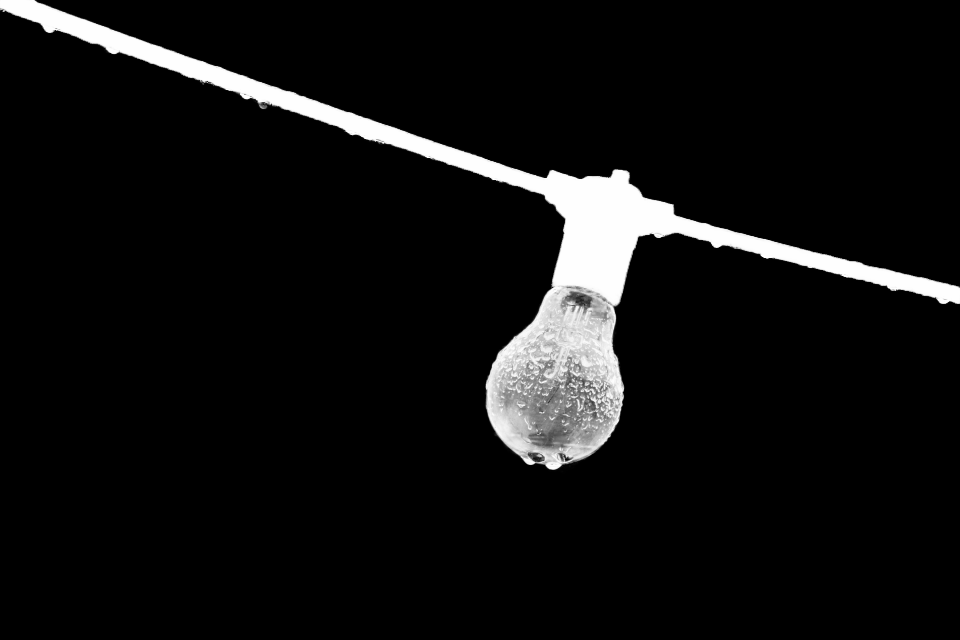

In [10]:
from torchvision.transforms import functional as F
alphas = outputs.alphas.flatten(0, 2)
prediction = F.to_pil_image(alphas)
prediction

# Visualizar el fondo

In [11]:
import PIL
def cal_foreground(image: PIL.Image, alpha: PIL.Image):
    """
    Calcular el foreground (primer plano) de la imagen.

    Returns:
        foreground: el primer plano de la imagen, numpy array
    """
    image = image.convert("RGB")
    alpha = alpha.convert("L")
    alpha = F.to_tensor(alpha).unsqueeze(0)
    image = F.to_tensor(image).unsqueeze(0)
    foreground = image * alpha + (1 - alpha)
    foreground = foreground.squeeze(0).permute(1, 2, 0).numpy()

    return foreground

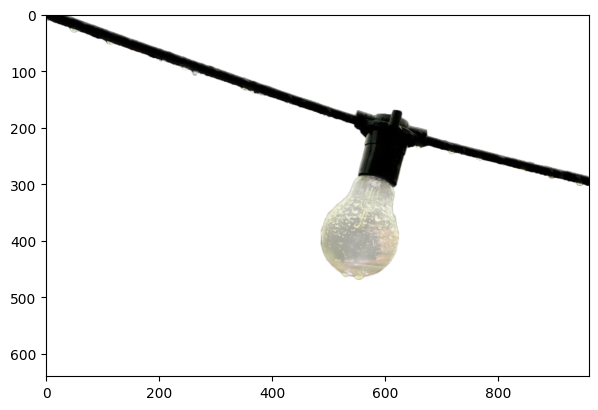

In [12]:
fg = cal_foreground(image, prediction)
plt.figure(figsize=(7, 7))
plt.imshow(fg)
plt.show()

# Modificar primer plano de otra imagen

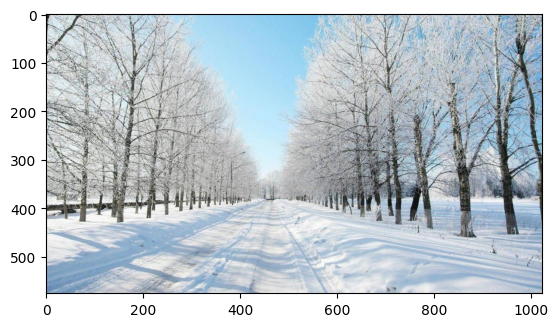

In [13]:
url = "https://github.com/hustvl/ViTMatte/blob/main/demo/new_bg.jpg?raw=true"
background = Image.open(requests.get(url, stream=True).raw).convert("RGB")

plt.imshow(background)

In [14]:

def merge_new_bg(image, background, alpha):
    """
    Merge el alpha matte con el nuevo background.

    Returns:
        foreground: el primer plano de la imagen, numpy array
    """
    image = image.convert('RGB')
    bg = background.convert('RGB')
    alpha = alpha.convert('L')
    image = F.to_tensor(image)
    bg = F.to_tensor(bg)
    bg = F.resize(bg, image.shape[-2:])
    alpha = F.to_tensor(alpha)
    new_image = image * alpha + bg * (1 - alpha)

    new_image = new_image.squeeze(0).permute(1, 2, 0).numpy()
    return new_image

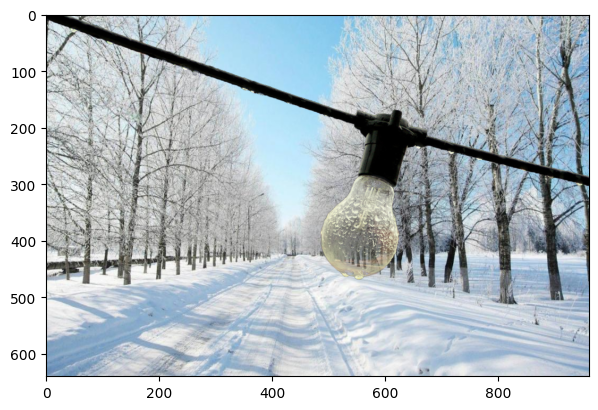

In [15]:
# mergear 
new_image = merge_new_bg(image, background, prediction)
plt.figure(figsize=(7, 7))
plt.imshow(new_image)
plt.show()

# Otro ejemplo

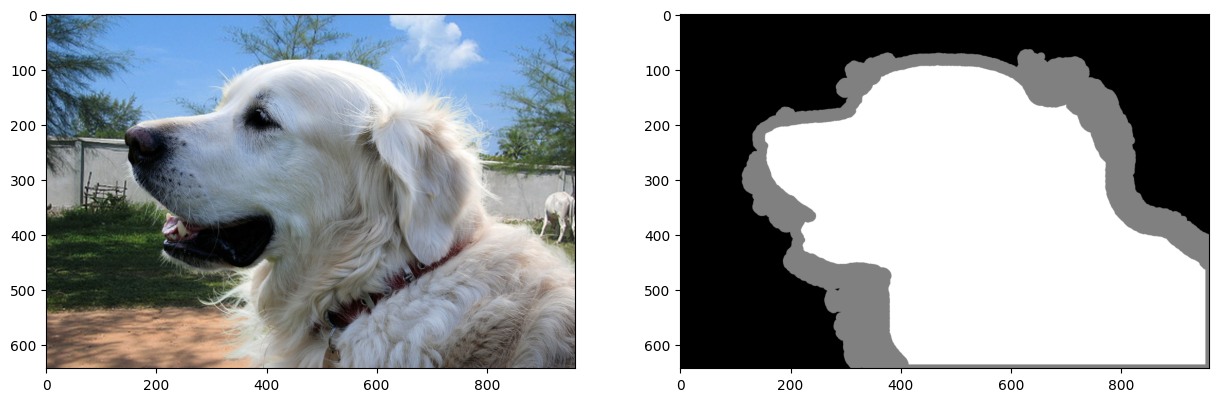

In [16]:
url = "https://github.com/hustvl/ViTMatte/blob/main/demo/retriever_rgb.png?raw=true"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
url = "https://github.com/hustvl/ViTMatte/blob/main/demo/retriever_trimap.png?raw=true"
trimap = Image.open(requests.get(url, stream=True).raw)

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(trimap)
plt.show()

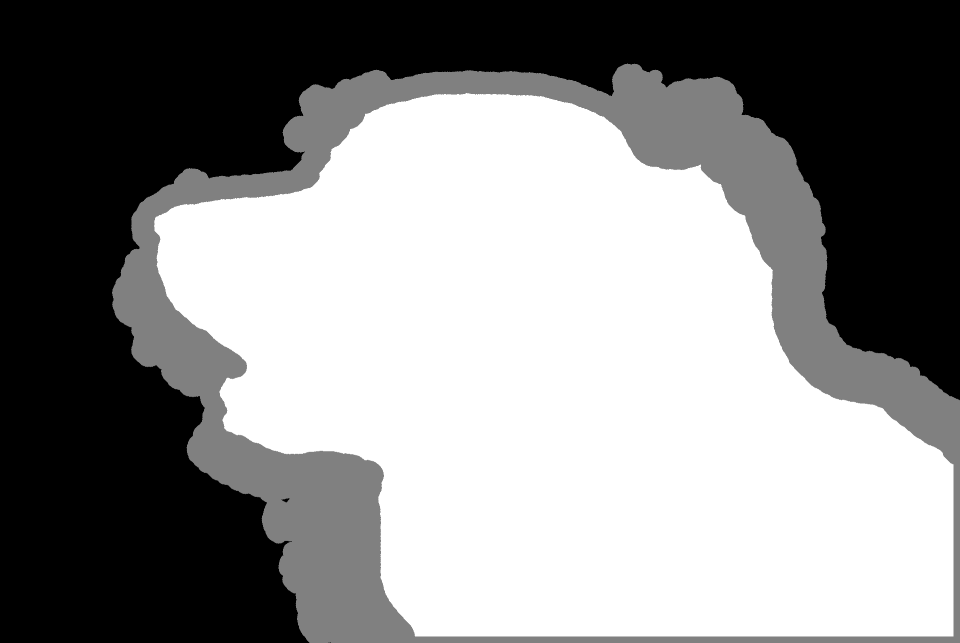

In [21]:
trimap

torch.Size([1, 4, 672, 960])
torch.Size([1, 1, 672, 960])
torch.Size([672, 960])


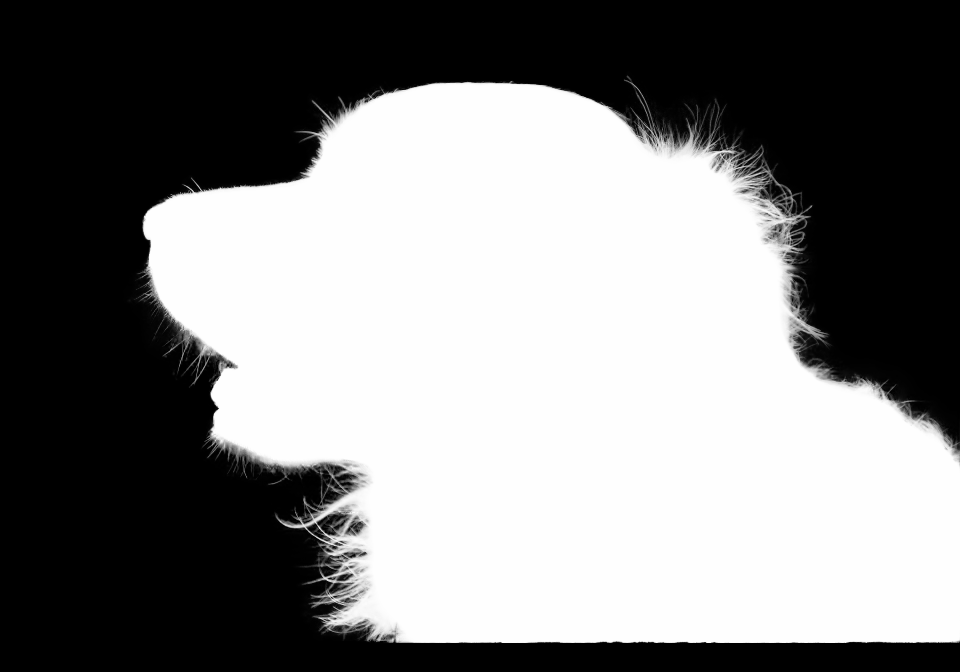

In [17]:
# preparar imagen + trimap para el modelo
pixel_values = processor(images=image, trimaps=trimap.convert("L"), return_tensors="pt").pixel_values
print(pixel_values.shape)
with torch.no_grad():
  outputs = model(pixel_values)
print(outputs.alphas.shape)
alphas = outputs.alphas.flatten(0, 2)
print(alphas.shape)
alphas = outputs.alphas.flatten(0, 2)
prediction = F.to_pil_image(alphas)
prediction

In [33]:
import PIL
def cal_foreground(image: PIL.Image, alpha: PIL.Image):
    """
    Calcular el foreground (primer plano) de la imagen.

    Returns:
        foreground: el primer plano de la imagen, numpy array
    """
    image = image.convert("RGB")
    alpha = alpha.convert("L")
    alpha = F.to_tensor(alpha).unsqueeze(0)[:,:,0:643,:]
    image = F.to_tensor(image).unsqueeze(0)
    foreground = image * alpha + (1 - alpha)
    foreground = foreground.squeeze(0).permute(1, 2, 0).numpy()

    return foreground

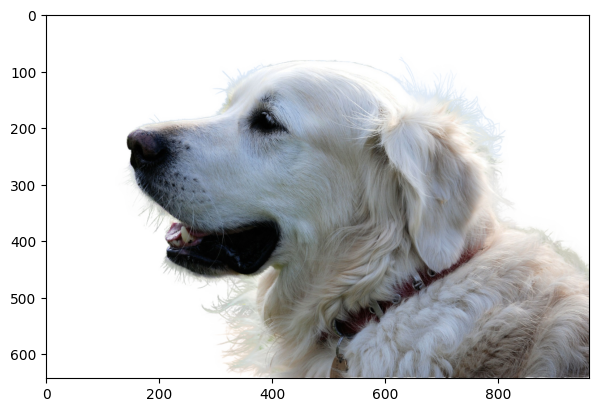

In [36]:
fg = cal_foreground(image, prediction)
plt.figure(figsize=(7, 7))
plt.imshow(fg)
plt.show()